# Loan Defaulter Classifier

In consumer finance, lending money is a delicate balance between opportunity and risk. Loan providing companies often face challenges in lending to individuals with insufficient or non-existent credit history, thus facing the challenge of identifying potential customers who can responsibly manage their loans. This project aims to tackle that challenge by analysing historical data to identify patterns that can help predict which applicants are likely to default on their loans. 

The lack of credit history information can lead to adverse outcomes, where some consumers exploit the situation and become defaulters. In this context, our project addresses two critical risks associated with loan approval decisions: 
* Opportunity Loss: Failing to approve loans for applicants who are capable of repaying them results in missed business opportunities.
* Financial Loss: Approving loans for applicants likely to default can lead to significant financial losses for the company.

*PS: We would strongly recommend using the headings sections of this notebook on Jupyter Lab/Notebook for easier accessibility.*

## Team Members
* Shruti Gajipara 121233882 shruti01@umd.edu
* Aayush Verma 121331076 aver23@umd.edu
* Premal Shah 121293596 shah1305@umd.edu
* Asutosh Dalei 120997754 asutoshd@umd.edu

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm


import os
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


## Datasets

In [56]:
colDesPath = r'/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/columns_description.csv'
appliPath = r'/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/application_data.csv'
prevAppliPath = r'/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/previous_application.csv'

for i in [colDesPath,appliPath,prevAppliPath]:
    print(str(i),":",os.path.getsize(i)/1e6,'mb')

/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/columns_description.csv : 0.028348 mb
/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/application_data.csv : 166.13337 mb
/Users/asutoshdalei/Desktop/Work/Loan-Defaulter-Classification/datasets/previous_application.csv : 404.973293 mb


In [57]:
%%time
columnDescription = pd.read_csv(colDesPath).drop(columns = ['Unnamed: 0'])
columnDescription.head()

CPU times: user 2.45 ms, sys: 1.13 ms, total: 3.58 ms
Wall time: 2.71 ms


,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_data,CODE_GENDER,Gender of the client,NaN
4,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [58]:
columnDescription.Table.value_counts()

Table
application_data            122
previous_application.csv     38
Name: count, dtype: int64

In [59]:
%%time
appData = pd.read_csv(appliPath)
print(appData.shape)
appData.head()

(307511, 122)
CPU times: user 1.02 s, sys: 173 ms, total: 1.19 s
Wall time: 1.21 s


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
defiFnx = lambda col,table='application_data': columnDescription[(columnDescription.Row == col) & (columnDescription.Table==table)]['Description'].item()

In [61]:
# Feature Creation: missingData. To indicate the % of datapoints missing in the row.
appData = appData.assign(missingData = appData.isna().mean(axis=1)*100)

In [62]:
# Correcting DAYS_EMPLOYED to work experience
appData['workExperience'] = (-appData['DAYS_EMPLOYED']/365).astype('float')
appData.drop(columns=['DAYS_EMPLOYED'],inplace=True)

#Number of cases where workExperience is less that 0. Since that is not possible, we will replace those rows with 0.
print("Number of cases with workEx < 0:", appData[appData['workExperience'] < 0].shape[0])

idx = appData[appData['workExperience'] < 0].index
appData.iloc[idx,appData.columns.get_loc('workExperience')] = 0

print("Number of cases with workEx < 0 after trasformation:", appData[appData['workExperience'] < 0].shape[0])

Number of cases with workEx < 0: 55374
Number of cases with workEx < 0 after trasformation: 0


In [63]:
# Dropping rows with wrong gender
appData = appData[appData['CODE_GENDER'] != 'XNA']

In [64]:
%%time
commCols = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']
appData['mobileCommunication'] = appData[commCols].sum(axis=1)#/len(commCols)
appData.drop(columns = commCols, inplace=True)

CPU times: user 57.5 ms, sys: 27.2 ms, total: 84.7 ms
Wall time: 88.6 ms


In [65]:
%%time
regCols = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
appData['region'] = appData[regCols].mean(axis=1)
appData.drop(columns = regCols, inplace=True)

CPU times: user 58.4 ms, sys: 23 ms, total: 81.4 ms
Wall time: 80.2 ms


In [66]:
%%time
amtCols = [col for col in appData.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
appData['creditB'] = appData[amtCols].sum(axis=1)
appData.drop(columns = amtCols, inplace=True)

CPU times: user 61.8 ms, sys: 22.8 ms, total: 84.6 ms
Wall time: 83.6 ms


In [67]:
docCols = [col for col in appData.columns  if 'DOCU' in col]
dropCols = []
for i in docCols:
    if i != 'FLAG_DOCUMENT_3':
        dropCols.append(i)
appData.drop(columns = dropCols, inplace=True)

In [68]:
idx = appData[appData['OWN_CAR_AGE'].notna()].index
appData.loc[idx,'OWN_CAR_AGE'] = 1

In [69]:
appData.isna().mean()

SK_ID_CURR             0.0
TARGET                 0.0
NAME_CONTRACT_TYPE     0.0
CODE_GENDER            0.0
FLAG_OWN_CAR           0.0
                      ... 
missingData            0.0
workExperience         0.0
mobileCommunication    0.0
region                 0.0
creditB                0.0
Length: 93, dtype: float64

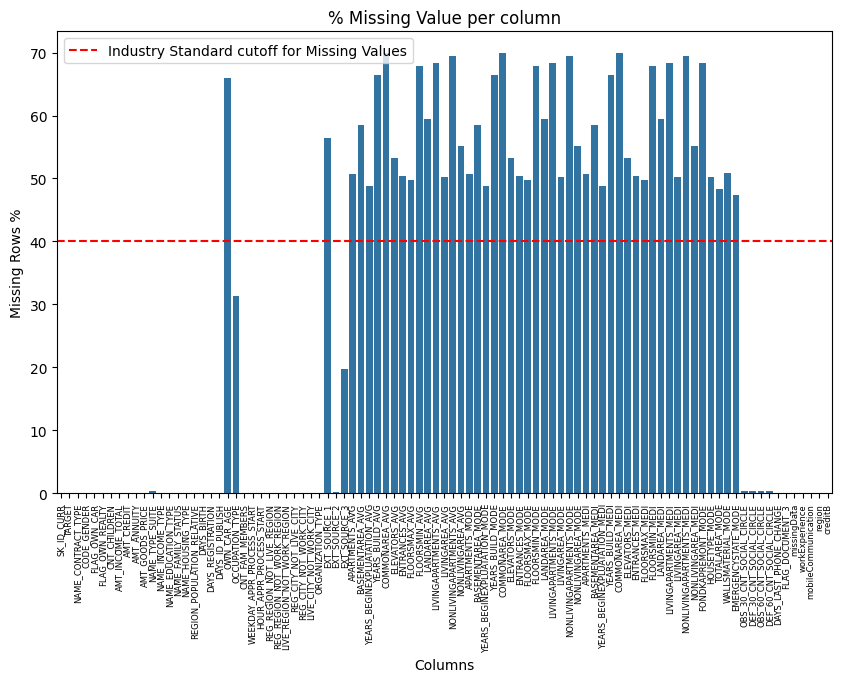

In [84]:
plt.figure(figsize=(10,6),dpi=100)
sns.barplot(data=appData.isna().mean()*100)
plt.axhline(y=40,color='red',linestyle = '--',label='Industry Standard cutoff for Missing Values')
plt.legend()
plt.xticks(rotation=90,fontsize=6)
plt.title('% Missing Value per column')
plt.xlabel('Columns')
plt.ylabel('Missing Rows %')
plt.show()

In [85]:
missingDataCol = appData.isna().mean()
missingDataCol[missingDataCol>0.4]

OWN_CAR_AGE                     0.659910
EXT_SOURCE_1                    0.563812
APARTMENTS_AVG                  0.507501
BASEMENTAREA_AVG                0.585164
YEARS_BEGINEXPLUATATION_AVG     0.487813
YEARS_BUILD_AVG                 0.664980
COMMONAREA_AVG                  0.698722
ELEVATORS_AVG                   0.532963
ENTRANCES_AVG                   0.503491
FLOORSMAX_AVG                   0.497611
FLOORSMIN_AVG                   0.678489
LANDAREA_AVG                    0.593769
LIVINGAPARTMENTS_AVG            0.683552
LIVINGAREA_AVG                  0.501937
NONLIVINGAPARTMENTS_AVG         0.694332
NONLIVINGAREA_AVG               0.551792
APARTMENTS_MODE                 0.507501
BASEMENTAREA_MODE               0.585164
YEARS_BEGINEXPLUATATION_MODE    0.487813
YEARS_BUILD_MODE                0.664980
COMMONAREA_MODE                 0.698722
ELEVATORS_MODE                  0.532963
ENTRANCES_MODE                  0.503491
FLOORSMAX_MODE                  0.497611
FLOORSMIN_MODE  

In [90]:
morethan_40percent_missing = missingDataCol[(missingDataCol>0.4)].index.tolist()
print(morethan_40percent_missing)

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE

### Realty Columns
* These columns are linked to housing details of applicants.
* The columns have a missing data percentage of more than 40 % and have poor correlation with the TARGET variable.
* Will be dropping them.

In [101]:
realty_ = []
for i in morethan_40percent_missing:
    if 'AVG' in i:
        realty_.append(i)
realty_  

['APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG']

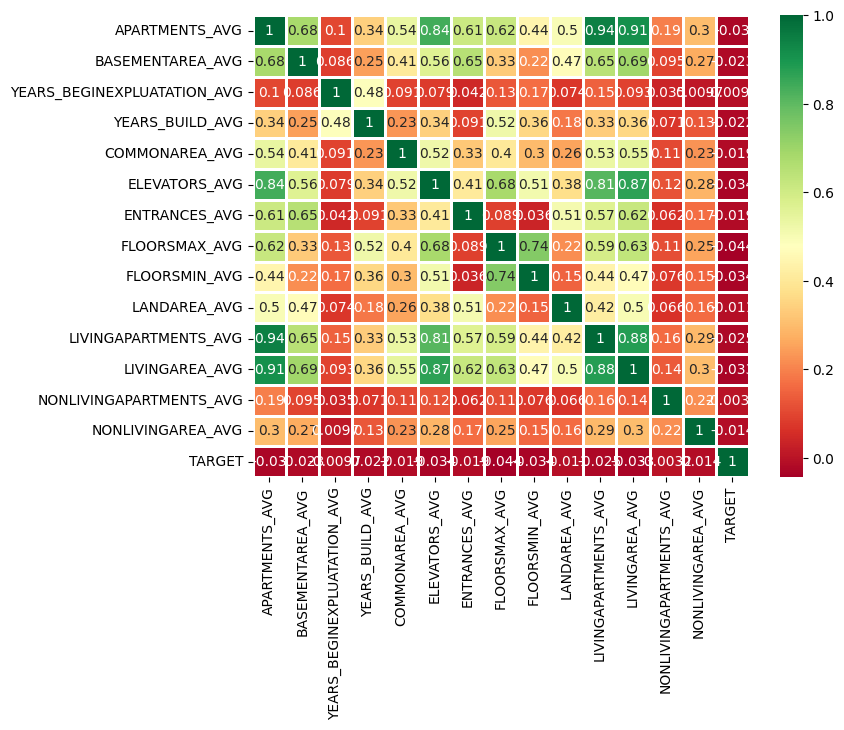

In [102]:
suspect_col = realty_ + ['TARGET']
suspect_corr = appData[suspect_col].corr()
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(suspect_corr,xticklabels=suspect_corr.columns,yticklabels=suspect_corr.columns,annot = True,cmap ="RdYlGn",linewidth=1)

In [96]:
suspect_corr

,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TARGET
APARTMENTS_MEDI,1.000000,0.680482,0.099966,0.338518,0.540782,0.837447,0.611437,0.614332,0.441132,0.500845,0.942485,0.915947,0.191532,0.297582,-0.029188
BASEMENTAREA_MEDI,0.680482,1.000000,0.076779,0.245787,0.406660,0.563022,0.651546,0.324330,0.216417,0.471898,0.651534,0.691403,0.095445,0.267337,-0.022082
YEARS_BEGINEXPLUATATION_MEDI,0.099966,0.076779,1.000000,0.427098,0.074254,0.077897,0.039868,0.125558,0.146238,0.068612,0.123111,0.088639,0.030913,0.010547,-0.009993
YEARS_BUILD_MEDI,0.338518,0.245787,0.427098,1.000000,0.232773,0.342919,0.087484,0.518319,0.359150,0.181314,0.334052,0.354030,0.069128,0.125148,-0.022326
COMMONAREA_MEDI,0.540782,0.406660,0.074254,0.232773,1.000000,0.522146,0.326369,0.401439,0.293397,0.260585,0.536983,0.548117,0.105943,0.228644,-0.018574
ELEVATORS_MEDI,0.837447,0.563022,0.077897,0.342919,0.522146,1.000000,0.404585,0.675786,0.508794,0.377773,0.814217,0.868340,0.121446,0.280025,-0.033866
ENTRANCES_MEDI,0.611437,0.651546,0.039868,0.087484,0.326369,0.404585,1.000000,0.082898,0.031977,0.510584,0.567218,0.618960,0.062345,0.165912,-0.019028
FLOORSMAX_MEDI,0.614332,0.324330,0.125558,0.518319,0.401439,0.675786,0.082898,1.000000,0.740411,0.219006,0.586422,0.626378,0.110862,0.247243,-0.043773
FLOORSMIN_MEDI,0.441132,0.216417,0.146238,0.359150,0.293397,0.508794,0.031977,0.740411,1.000000,0.150376,0.437311,0.463338,0.073854,0.145821,-0.033400
LANDAREA_MEDI,0.500845,0.471898,0.068612,0.181314,0.260585,0.377773,0.510584,0.219006,0.150376,1.000000,0.426370,0.503887,0.065388,0.166139,-0.011258


In [104]:
realty_ = []
for i in morethan_40percent_missing:
    if ('AVG' in i) or ('MEDI' in i) or ('MODE' in i):
        realty_.append(i)

appData.drop(columns = realty_, inplace=True)
appData.shape

In [105]:
appData.shape

(307507, 46)

## Columns Under Consideration

In [ ]:
cols = ['TARGET','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN']